<a href="https://colab.research.google.com/github/Arden-Zhu/fashion_net2/blob/master/A_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 1

In [0]:
import os
import time
from typing import *
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from IPython.display import display 


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
my_drive_dir = "/content/gdrive/My Drive/Machine Learning"

Mounted at /content/gdrive


## Helper functions

In [0]:
def is_listy(x:Any)->bool: return isinstance(x, (tuple,list))
def is_tuple(x:Any)->bool: return isinstance(x, tuple)
def is_dict(x:Any)->bool: return isinstance(x, dict)


## prepare images

In [0]:
since = time.time()
data_source_dir = os.path.join(my_drive_dir, 'Datasets\DeepFashion\Category and Attribute Prediction Benchmark'.replace('\\', '/'))
tar_file = os.path.join(data_source_dir, 'picked.tar')
if not os.path.exists('data'):
  os.mkdir('data')
! tar xf "{tar_file}" -C data/
print('%.3f' % (time.time() - since))

5.946


In [0]:
csv_file = os.path.join(data_source_dir, 'picked.csv')
df = pd.read_csv(csv_file, index_col=0)
df = df.loc[:, ['file', 'category_name', 'category_id']]
df['file'] = df.apply(lambda m: m.file[4:], axis=1)
df.head()

,file,category_name,category_id
23063,Kimono-Sleeved_Paisley_Blouse/img_00000121.jpg,Blouse,3
30780,Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg,Blouse,3
13998,Crochet_Lace-Paneled_Blouse/img_00000035.jpg,Blouse,3
123023,New_York_City_Pocket_Tee/img_00000012.jpg,Tee,18
21889,Georgette_Tulip_Back_Blouse/img_00000029.jpg,Blouse,3


In [0]:
def pick(n_train, n_val, categories):
  df_pick = pd.DataFrame(columns=['file', 'label', 'type'])

  for cat in categories:
    indexes = df.loc[df.category_name == cat].index.values
    indexes = np.random.permutation(indexes)

    # trainset
    df_slice = df.loc[indexes[:n_train]].loc[:, ['file', 'category_name']]
    df_slice.columns = ['file', 'label']
    df_slice['type'] = 'train'

    df_pick = pd.concat([df_pick, df_slice])
    # valset
    df_slice = df.loc[indexes[n_train:n_train + n_val]].loc[:, ['file', 'category_name']]
    df_slice.columns = ['file', 'label']
    df_slice['type'] = 'val'
    df_pick = pd.concat([df_pick, df_slice])

  return df_pick

#############
df_pick = pick(2, 1, ['Tee', 'Blouse', 'Top'])
df_pick.head(10)


,file,label,type
39758,Boxy_Winged_Tee/img_00000009.jpg,Tee,train
43962,Striped_Longline_Baseball_Tee/img_00000020.jpg,Tee,train
56005,Varsity-Striped_18_Tee/img_00000017.jpg,Tee,val
3039,Striped_Tribal_Print_Blouse/img_00000081.jpg,Blouse,train
23196,Beaded_Chiffon_Blouse/img_00000010.jpg,Blouse,train
3037,Striped_Tribal_Print_Blouse/img_00000079.jpg,Blouse,val
33264,Boxy_Palm_Print_Top/img_00000032.jpg,Top,train
61964,Cami_Peplum_Top/img_00000044.jpg,Top,train
70839,Collared_Woven_Top/img_00000017.jpg,Top,val


In [0]:
df_pick = pick(500, 200, ['Tee', 'Blouse', 'Top'])

## DataSource

Tee
(224, 224)


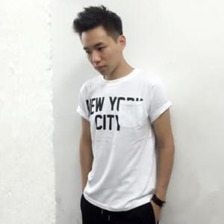

In [0]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

class ImageLabelDataset(Dataset):
  '''
  a dataset provides (image, label)
  '''
  def __init__(self, path:str, image_files, labels, transform=None, 
               normalize = imagenet_stats):
    self.path = path
    self.image_files = image_files
    self.labels = labels
    self.transform = transform
    if normalize:
      self.normalizer = transforms.Normalize(normalize[0], normalize[1])

    assert(len(image_files) == len(labels))

  def __len__(self):
    return len(self.labels)
  
  def get(self, idx):
    file = os.path.join(self.path, self.image_files[idx])
    
    #image = io.imread(file)
    #image = Image.fromarray(image)
    image = Image.open(file)
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return (image, label)

  def __getitem__(self, idx):
    image, label = self.get(idx)

    image = transforms.ToTensor()(image)

    if self.normalizer:
      image = self.normalizer(image)

    return (image, label)

##############################
image_ds = ImageLabelDataset('data/data/picked', ['New_York_City_Pocket_Tee/img_00000012.jpg'], ['Tee'], transform =  transforms.Resize(224))
assert(len(image_ds) == 1)

(image, label) = image_ds.get(0)
print(label)
assert(label == 'Tee')    

print(image.size)

display(image)

In [0]:
class DataSource():
  '''
  train_dl
  val_dl
  train_ds
  val_dl
  '''
  def __init__(self, path:str, df:pd.DataFrame, bs:int, transforms=None, 
               num_workers=0, normalize = imagenet_stats):
      '''
      path : path of images
      df : DataFrame with file, label, type
      '''
      # convert labels to number
      labels = np.sort(df['label'].unique())
      self.class_names = np.sort(df['label'].unique())
      self.class_indexes = {c:i for i, c in enumerate(self.class_names)}
      self.c = len(self.class_names)
      self.labels = [self.class_indexes[c] for c in labels]

      # transforms
      if not is_listy(transforms):
        train_tfm, val_tfm = transforms, transforms
      elif len(transforms) == 0:
        train_tfm, val_tfm = None, None
      elif len(transforms) == 1:
        train_tfm, val_tfm = transforms[0], transforms[0]
      else:
        train_tfm, val_tfm = transforms[0], transforms[1]

      # dataset
      is_train = df.type == 'train'
      self.train_ds = ImageLabelDataset(path, df[is_train]['file'].values, 
                                           [self.class_indexes[c] for c in df[is_train]['label'].values], 
                                           train_tfm, 
                                           normalize)
      self.val_ds = ImageLabelDataset(path, df[~is_train]['file'].values, 
                                          [self.class_indexes[c] for c in df[~is_train]['label'].values], 
                                          val_tfm,
                                          normalize
                                       )

      # dataloader
      self.train_dl = DataLoader(self.train_ds, batch_size=bs, shuffle=True, 
                                 num_workers=num_workers)
      
      self.val_dl = DataLoader(self.val_ds, batch_size=bs, shuffle=False, 
                                 num_workers=num_workers)

############################################################################
df2 = df.head(3).copy()
df2.columns=['file', 'type', 'label']
df2['type'] = ['train', 'val', 'train']
df2['label'] = ['a', 'b', 'c']
print(df2.head())

ds = DataSource('data/data/picked', df2, 1)
assert(len(ds.train_ds) == 2)
assert(len(ds.val_ds) == 1)
assert(ds.c == 3)
assert(ds.val_ds[0][1] == 1)
assert(ds.class_names[ds.val_ds[0][1]] == 'b')

for (image, label) in ds.val_dl:
  print(type(image))
  print(image.shape)
  print(label)
  print(image[0, 0, 0, :20])
  break

                                                 file   type label
23063  Kimono-Sleeved_Paisley_Blouse/img_00000121.jpg  train     a
30780     Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg    val     b
13998    Crochet_Lace-Paneled_Blouse/img_00000035.jpg  train     c
<class 'torch.Tensor'>
torch.Size([1, 3, 300, 207])
tensor([1])
tensor([2.1633, 2.1633, 2.1462, 2.1462, 2.1290, 2.1290, 2.1119, 2.1119, 2.1290,
        2.1290, 2.1290, 2.1119, 2.1119, 2.1119, 2.0948, 2.0948, 2.1119, 2.1119,
        2.1119, 2.1119])


## Transformation

In [0]:
def padToSquare(img, **kwargs):
    """Pad the input PIL Image to a square

    Args:
        img (PIL Image): Image to be resized.

    Returns:
        PIL Image: Padding image.
    """
    if not TF._is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
    
    w, h = img.size
    diff = w - h

    if diff == 0:
      return img
    else:
      if diff < 0:
        padding = (-diff // 2, 0, diff // 2 - diff, 0)
      else:
        padding = (0, diff // 2, 0, diff - diff//2)

      return TF.pad(img, padding, **kwargs)

In [0]:
class PadToSquare():
    """ Pad the input PIL Image to a square
    """
    def __init__(self, **kwargs):
      self.params = kwargs

    def __call__(self, x):
      return padToSquare(x, **self.params)


In [0]:
def tensor2img(tensor, stats):
  mean, std = stats
  img = tensor.numpy().transpose([1, 2, 0])
  img = img * std + mean
  img = np.minimum(img, 1)
  img = np.maximum(img, 0)
  return img


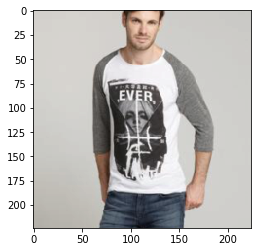

In [0]:
df_pick = pick(200, 50, ['Tee', 'Blouse', 'Top'])
tfms = [
  transforms.Compose([
    PadToSquare(padding_mode='reflect'),
    transforms.Resize(256),
    transforms.RandomCrop(224),
  ]),
  transforms.Compose([
    PadToSquare(padding_mode='reflect'),
    transforms.Resize(256),
    transforms.CenterCrop(224),
  ]),
]

ds = DataSource('data/data/picked', df_pick, 4, num_workers=4, transforms=tfms)

images, labels = next(iter(ds.train_dl))

images.shape

img = tensor2img(images[0], imagenet_stats)
plt.imshow(img)
plt.show()

## train

In [0]:
class Classback:
  def on_train_begin():
    pass
  
  def on_train_end():
    pass

  def on_epoch_begin(epoch:int):
    pass

  def on_epoch_end(loss, accuracy):
    pass

  def on_batch_begin():
    pass

  def on_batch_end():
    pass

  def on_phrase_begin():
    pass

  def on_phrase_end():
    pass

  def need_val(epoch):
    return True

In [0]:
class Learn():
  def __init__(self, ds:DataSource, net:nn.Module, crit, cbs):
    self.ds = ds
    self.net = net
    self.crit = crit
    self.cbs = cbs
    self.dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  def train_batch(self, X, y, is_train, opt):
      self.batch_start(is_train)

      X, y = X.to(dev), y.to(dev)
      dev, net, crit = self.dev, self.net, self.crit

      opt.zero_grad()
      with torch.set_grad_enabled(is_train):
        a = net.forward(X)
        loss = crit(a, y)
        if is_train:
          loss.backward()
          opt.step()

      cnt += y.size(0)
      total_loss += loss.item() * cnt
      y_hat = torch.argmax(a, 1)
      correct += torch.sum(y_hat == y).item()

      is_terminate = self.batch_end(is_train, opt, cnt, total_loss, correct)

  def train_phrase(self, is_train, opt):
    total_loss, cnt, correct = 0, 0, 0
    dev, net, crit = self.dev, self.net, self.crit
    is_terminate = False

    self.phrase_begin(is_train)

    net.train(is_train)

    for X, y in (ds.train_dl if is_train else ds.val_dl):

      if is_terminate: break

    avg_loss = total_loss/cnt if cnt > 0 else math.nan
    accuracy = correct/cnt if cnt > 0 else math.nan
    is_terminate = self.phrase_end(is_train, avg_loss, accuracy) or is_terminate

    return avg_loss, accuracy, is_terminate


  def train(n_epoch:int, opt):
    is_terminate = False

    self.train_begin()

    net = net.to(dev)
    for epoch in range(n_epoch):
      loss_train, accuracy_train = math.nan, math.nan
      loss_val, accuracy_val = math.nan, math.nan

      self.epoch_start(epoch)

      loss_train, accuracy_train, is_terminate = train_phrase(True, opt)

      if (not is_terminate) and self.need_val(epoch):
        loss_val, accuracy_val, is_terminate = train_phrase(False, opt)

      self.epoch_end(is_terminate, epoch)
      if is_terminate: break

    self.train_end(is_terminate)

  def phrase_begin(self, is_train):
    for cb in self.cbs:
      cb.on_phrase_begin(is_train)

  def phrase_end(self, is_train, avg_loss, accuracy):
    for cb in self.cbs:
      cb.on_phrase_end(is_train, avg_loss, accuracy)

  def need_val(self, epoch):
    is_needed = True
    for cb in self.cbs:
      is_needed = is_needed and cb.need_val(epoch)



####################################################
df_pick = pick(128, 64, ['Tee', 'Blouse', 'Top'])
tfmt1 = transforms.Compose([
         PadToSquare(padding_mode='reflect'),
         transforms.Resize(256),
         transforms.RandomCrop(224)
]);
tfmt2 = transforms.Compose([
         PadToSquare(padding_mode='reflect'),
         transforms.Resize(256),
         transforms.CenterCrop(224)
]);

tfmts = [ tfmt1, tfmt2 ]
ds = DataSource('data/data/picked', df_pick, 32, tfmts, num_workers=4)

net = models.resnet18(pretrained=True, progress=False)
net.fc = nn.Linear(net.fc.in_features, ds.c)

criterion = nn.CrossEntropyLoss()

opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.95)

dev = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

sch = None # optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

net.train()
train(20, ds, net, criterion, opt, sch, dev)


SyntaxError: ignored

In [67]:
for i in range(5):
  if i==3: break;
  print(i)

0
1
2
